# Introduction

In this notebook, we will be analyzing character and actor first names from popular television shows.

## Import Libraries

In [1]:
#Import necessary libraries 
import numpy as np
import pandas as pd
import csv
import os
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import mplcursors
import mpld3

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
#Load national data from SSA
national_df = pd.read_csv("Data/national_data.csv")
#Load state data from SSA
states_df = pd.read_csv("Data/states_data.csv")

In [3]:
#Create groupby to show all name count per year for both sexes
national_group_df = national_df.groupby(['name','year'])['count'].sum().reset_index()

national_df.head()

,name,sex,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


### Creat Function to Plot Names

In [4]:
#Create function to plot a single name over time
def plot_name_trend(df, name_to_plot, show_year=None, show_name=None):
    """
    Plot the trend of a specific name over time.

    Parameters:
        df (DataFrame): DataFrame containing name data.
        name_to_plot (str): Name for which the trend will be plotted.
    """
    # Filter data for the specified name
    name_data = df[df['name'] == name_to_plot]
    
    # Aggregate counts by year
    name_counts_by_year = name_data.groupby('year')['count'].sum().reset_index()

    # Plot the trend
    plt.figure(figsize=(10, 6))
    plt.plot(name_counts_by_year['year'], name_counts_by_year['count'], marker='o')

    # Add a line and annotation for the TV show's release year
    if show_year is not None:
        plt.axvline(x=show_year, color='red', linestyle='--')  # Add a vertical line
        
        # Calculate the position for annotation based on the maximum count value
        max_count = name_counts_by_year['count'].max()
        annotation_y = max_count + 0.05 * max_count  # Adjust for annotation position
        
        if show_name:
            annotation_text = f'{show_name} Release'
        else:
            annotation_text = 'TV Show Release'
            
        plt.annotate(annotation_text, xy=(show_year, max_count), xytext=(show_year + 2, annotation_y),
                     arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12)

    # Add labels and title
    plt.title(f'Trend of Name "{name_to_plot}" Over Time')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

### Create Function to Calculate Name Popularity Increase

In [5]:
def calculate_popularity_increase(df, name, year1, year2):
    # Filter dataframe for years of interest 
    filtered_df = df[((df['name'] == name) & (df['year'] == year1)) | ((df['name'] == name) & (df['year'] == year2))]

    # Group by 'name' and aggregate counts for each year
    grouped_df = filtered_df.groupby(['name', 'year']).sum().unstack()

    # Calculate increase in popularity
    popularity_increase = ((grouped_df['count'][year2].values[0] - grouped_df['count'][year1].values[0]) / 
                           grouped_df['count'][year1].values[0]) * 100

    # Round to two decimals
    popularity_increase = str(round(popularity_increase, 2)) + "%"
     
    return popularity_increase

### Define Function to get Wiki Data

Get character or actor names from list of main casts on wikiperdia. 

In [6]:
# Adapated code from https://www.geeksforgeeks.org/web-scraping-from-wikipedia-using-python-a-complete-guide/
# Adapated code from https://www.geeksforgeeks.org/web-scraping-from-wikipedia-using-python-a-complete-guide/
# Debugged using geenrative AI
def extract_character_names(url, column_index, column_name=None):
    # Send a GET request to the URL
    response = requests.get(url)
    
    if response.status_code != 200:
        print("Failed to retrieve data from the URL:", url)
        return None

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table containing the character names
    table = soup.find('table', class_='wikitable')

    if table is None:
        print("Table not found in the HTML content.")
        return None

    # Initialize a list to store character names
    characters = []

    # Extract character names from the table rows
    rows = table.find_all('tr')[1:]  # Skip the header row
    for row in rows:
        # Find the cell containing the character name
        cells = row.find_all('td')
        if len(cells) >= column_index + 1:  # Ensure the row has enough cells
            character_name = cells[column_index].get_text(strip=True)
            characters.append(character_name)

    # Path to the "Data" folder
    data_folder = "Data"

    # Ensure the "Data" folder exists
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    # Write character names to a CSV file in the "Data" folder
    csv_filename = os.path.join(data_folder, f"{url.split('/')[-1]}_characters.csv")
    with open(csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        if column_name:
            writer.writerow([column_name])
        writer.writerows([[char] for char in characters])

    # Load dataframe
    df = pd.read_csv(csv_filename)
    return df

### Create Show Dataframes

In [7]:
# Wikipedia URL of Bridgerton characters
bridgerton_url = 'https://en.wikipedia.org/wiki/List_of_Bridgerton_characters'
bridgerton_df = extract_character_names(bridgerton_url, column_index=1,column_name= 'character_name')

# Wikipedia URL of Stranger Things actors
stranger_things_url = 'https://en.wikipedia.org/wiki/List_of_Stranger_Things_characters'
stranger_things_df = extract_character_names(stranger_things_url, column_index=0,column_name ='actor_name')

# Wikipedia URL of Game of Thrones actors 
game_of_thrones_url = 'https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_characters'
game_of_thrones_df = extract_character_names(game_of_thrones_url, column_index=0,column_name = 'actor_name')

### Clean Bridgerton Character Names

In [8]:
#remove characters without first names on show
bridgerton_df = bridgerton_df[~bridgerton_df['character_name'].isin(['Mrs Varley','Lady Whistledown', 'Lady Danbury'])]

#Replace character name on credits to include first name
bridgerton_df['character_name'] = bridgerton_df['character_name'].replace('Lady Danbury', 'Agatha Danbury')


exact_matches_to_replace = ['Does not appear']

prefixes_to_remove = ['Lady','Mrs','King','Dowager Princess','Queen']


# Function to clean names based on criteria
def clean_names(name):
    # Replace exact matches with NaN
    if name in exact_matches_to_replace:
        return np.nan
    
    # Remove prefixes from names
    for prefix in prefixes_to_remove:
        if name.startswith(prefix):
            return name[len(prefix):].strip()
    
    return name


# Apply cleaning function to the characters column
bridgerton_df['cleaned_character_name'] = bridgerton_df['character_name'].apply(lambda x: clean_names(x))

# Get non Nan values from column
bridgerton_df = bridgerton_df[bridgerton_df['cleaned_character_name'].notna()]

# Display cleaned DataFrame
bridgerton_df.head()

,character_name,cleaned_character_name
4,Anthony Bridgerton,Anthony Bridgerton
5,Marina Thompson,Marina Thompson
6,Siena Rosso,Siena Rosso
7,Philippa Featherington,Philippa Featherington
8,Prudence Featherington,Prudence Featherington


### Define Function to Extract First Names

In [9]:
# Create function to extract first name
def extract_first_name(full_name):
    # Split the full name
    name_parts = full_name.split()
    # Check if there is at least one name
    if len(name_parts) > 0:
        # Return the first name
        return name_parts[0]
    else:
        # If no first name, return None
        return None

### Apply function to Bridgerton dataframe

In [10]:
# Apply function to create new column
bridgerton_df['character_first_name'] = bridgerton_df['cleaned_character_name'].apply(lambda x: extract_first_name(x))

# Display the updated DataFrame
bridgerton_df.head()

,character_name,cleaned_character_name,character_first_name
4,Anthony Bridgerton,Anthony Bridgerton,Anthony
5,Marina Thompson,Marina Thompson,Marina
6,Siena Rosso,Siena Rosso,Siena
7,Philippa Featherington,Philippa Featherington,Philippa
8,Prudence Featherington,Prudence Featherington,Prudence


### Define function to filter national name data for names from show

In [11]:
def filter_and_group_names(national_df, character_df, character_column):
    # Filter national_df for character names
    filtered_names_df = national_df[national_df['name'].isin(character_df[character_column])]

    # Group by name and year, summing the counts
    grouped_names_df = filtered_names_df.groupby(['name', 'year']).sum().reset_index()

    return grouped_names_df

## Analysis

### Bridgerton Analysis

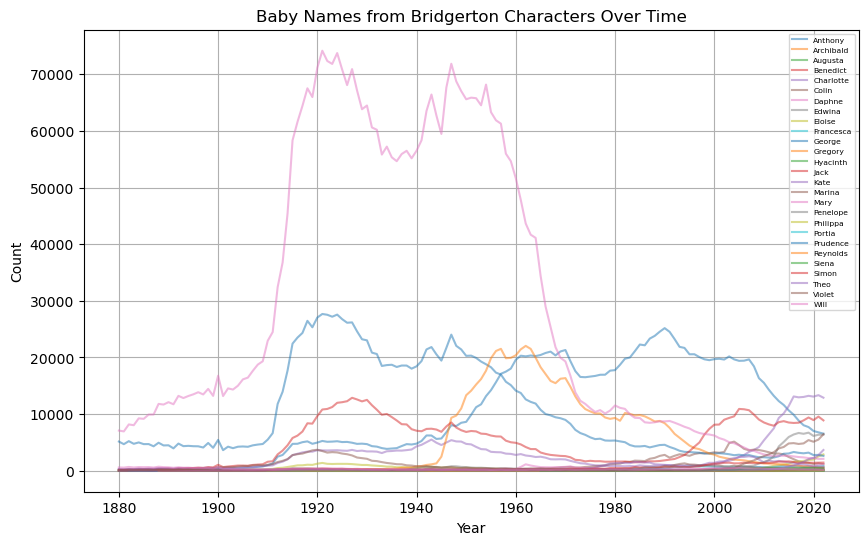

In [12]:
grouped_bridgerton_df = filter_and_group_names(national_df, bridgerton_df, 'character_first_name')

plt.figure(figsize=(10, 6))
lines = []
for name, data in grouped_bridgerton_df.groupby('name'):
    line, = plt.plot(data['year'], data['count'], label=name, alpha=0.5)
    lines.append(line)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Baby Names from Bridgerton Characters Over Time')

plt.legend(fontsize='5.5')

plt.grid(True)

# Add hover
cursor = mplcursors.cursor(hover=True)

#below hover section code configuration was assisted by generatiove AI
@cursor.connect("add")
def on_hover(sel):
    sel.annotation.set_text(sel.artist.get_label())
    for line in lines:
        if line != sel.artist:
            line.set_alpha(0.2)  # Grey out non hover lines
        else:
            line.set_alpha(1.0)  # Highlight hover line

plt.show()

### Stranger Things Analysis

In [13]:
# Apply function to create new column
stranger_things_df['actor_first_name'] = stranger_things_df['actor_name'].apply(lambda x: extract_first_name(x))

# Display the updated DataFrame
stranger_things_df.head()

,actor_name,actor_first_name
0,Winona Ryder,Winona
1,David Harbour,David
2,Finn Wolfhard,Finn
3,Millie Bobby Brown[a],Millie
4,Gaten Matarazzo,Gaten


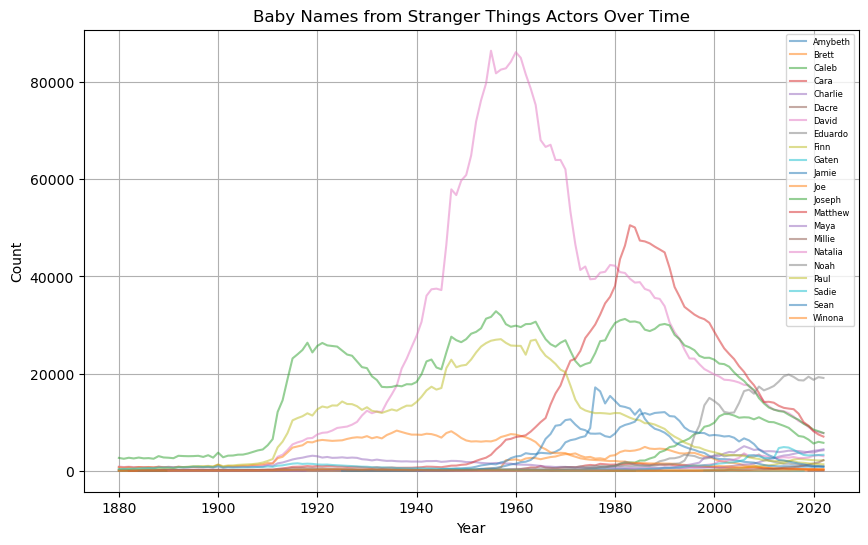

In [14]:
grouped_stranger_things_df = filter_and_group_names(national_df, stranger_things_df, 'actor_first_name')

plt.figure(figsize=(10, 6))
lines = []
for name, data in grouped_stranger_things_df.groupby('name'):
    line, = plt.plot(data['year'], data['count'], label=name, alpha=0.5)
    lines.append(line)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Baby Names from Stranger Things Actors Over Time')

plt.legend(fontsize='6')

plt.grid(True)

# Add hover
cursor = mplcursors.cursor(hover=True)

#below hover section code configuration was assisted by generatiove AI
@cursor.connect("add")
def on_hover(sel):
    sel.annotation.set_text(sel.artist.get_label())  # Display label name
    for line in lines:
        if line != sel.artist:
            line.set_alpha(0.2)  # Grey out non hover lines
        else:
            line.set_alpha(1.0)  # Highlight hovered line

plt.show()

In [15]:
# Get name counts for "Millie" 
national_group_df[(national_group_df['name'] == 'Millie') & (national_group_df['year'] > 2000)]


,name,year,count
1294553,Millie,2001,84
1294554,Millie,2002,91
1294555,Millie,2003,174
1294556,Millie,2004,144
1294557,Millie,2005,130
1294558,Millie,2006,133
1294559,Millie,2007,151
1294560,Millie,2008,261
1294561,Millie,2009,320
1294562,Millie,2010,311


In [16]:
calculate_popularity_increase(national_group_df, 'Millie', 2016, 2022)

'194.47%'

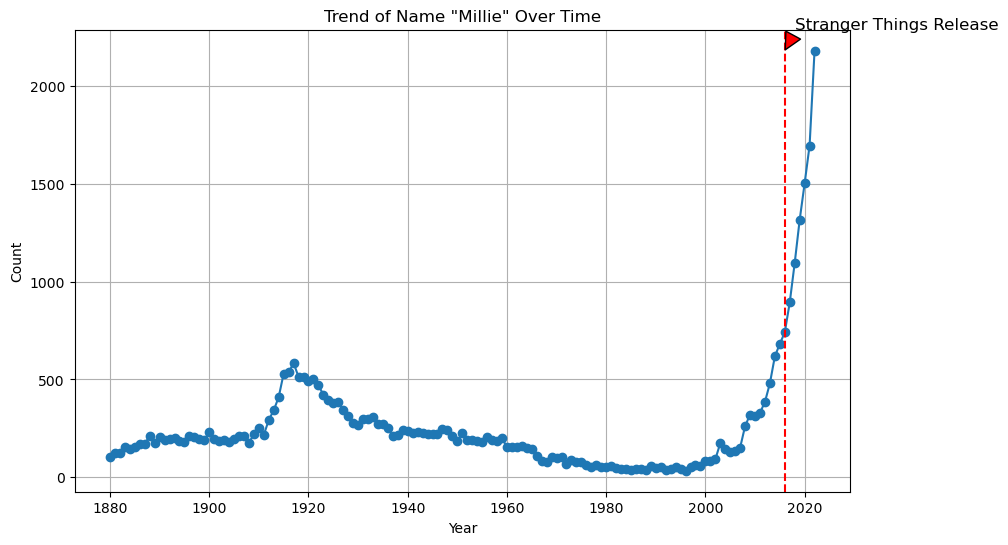

In [17]:
#Plot name Millie for Actress Millie Bobby Brown
plot_name_trend(national_df, 'Millie', show_year=2016, show_name="Stranger Things")

In [18]:
# Get name counts for "Millie" 
national_group_df[(national_group_df['name'] == 'Finn') & (national_group_df['year'] > 1995)]

,name,year,count
625441,Finn,1996,42
625442,Finn,1997,46
625443,Finn,1998,93
625444,Finn,1999,130
625445,Finn,2000,203
625446,Finn,2001,215
625447,Finn,2002,218
625448,Finn,2003,308
625449,Finn,2004,408
625450,Finn,2005,470


In [19]:
# Calculate popularity increase for 'Finn'
calculate_popularity_increase(national_group_df, 'Finn', 1998, 2017)

'2496.77%'

In [20]:
# Calculate popularity increase for 'Finn'
calculate_popularity_increase(national_group_df, 'Finn', 2017, 2021)

'-12.55%'

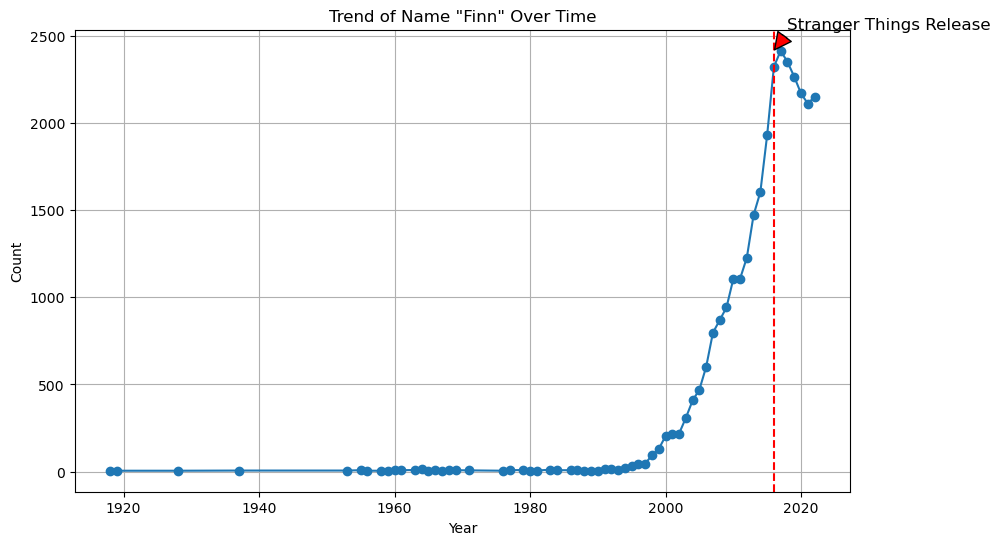

In [21]:
#Plot name Finn for Actress Finn Wolfhard
plot_name_trend(national_df, 'Finn', show_year=2016, show_name="Stranger Things")

### Game of Thrones Analysis

In [22]:
# Apply function to create new column
game_of_thrones_df['actor_first_name'] = game_of_thrones_df['actor_name'].apply(lambda x: extract_first_name(x))

# Display updated DataFrame
game_of_thrones_df.head()

,actor_name,actor_first_name
0,Sean Bean,Sean
1,Mark Addy,Mark
2,Nikolaj Coster-Waldau,Nikolaj
3,Michelle Fairley,Michelle
4,Lena Headey,Lena


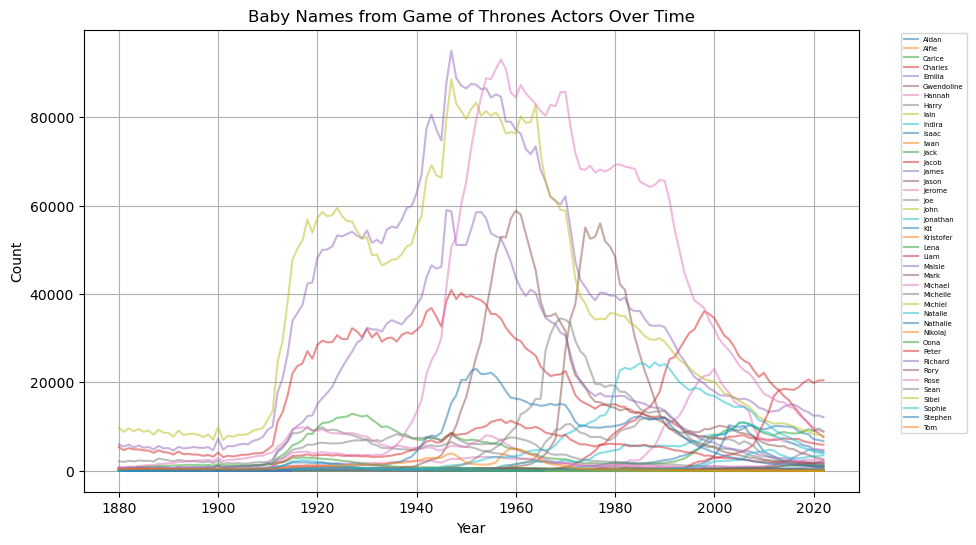

In [23]:
grouped_game_of_thrones_df = filter_and_group_names(national_df, game_of_thrones_df, 'actor_first_name')

plt.figure(figsize=(10, 6))
lines = []
for name, data in grouped_game_of_thrones_df.groupby('name'):
    line, = plt.plot(data['year'], data['count'], label=name, alpha=0.5)  # Set alpha to 0.5 to grey out lines
    lines.append(line)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Baby Names from Game of Thrones Actors Over Time')

plt.grid(True)

# Add hover
cursor = mplcursors.cursor(hover=True)

#below hover section code configuration was assisted by generatiove AI
@cursor.connect("add")
def on_hover(sel):
    sel.annotation.set_text(sel.artist.get_label())
    for line in lines:
        if line != sel.artist:
            line.set_alpha(0.2)  # Grey out non hover lines
        else:
            line.set_alpha(1.0)  # Highlight hovered line

# Move legend outside plot
plt.legend(fontsize='5', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [24]:
# Get name counts for "Jon" 
national_group_df[(national_group_df['name'] == 'Kit') & (national_group_df['year'] > 2000)]

,name,year,count
1015107,Kit,2001,27
1015108,Kit,2002,12
1015109,Kit,2003,10
1015110,Kit,2004,23
1015111,Kit,2005,20
1015112,Kit,2006,7
1015113,Kit,2007,14
1015114,Kit,2008,17
1015115,Kit,2009,24
1015116,Kit,2010,23


In [25]:
# Calculate popularity increase for 'Kit'
print("Popularity Increase for Kit:")
calculate_popularity_increase(national_group_df, 'Kit', 2014, 2022)

Popularity Increase for Kit:


'718.92%'

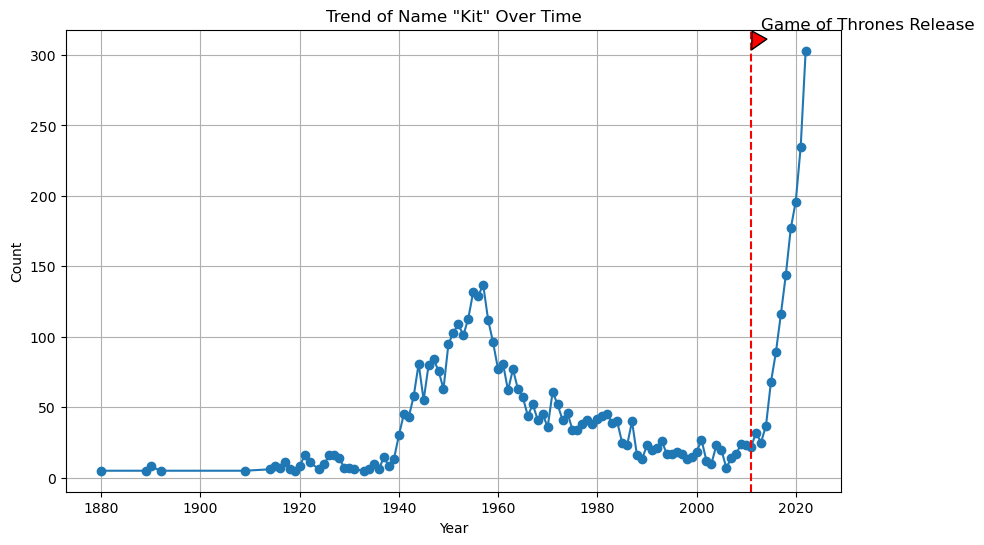

In [26]:
# Plot name of Kit for Kit Harington
plot_name_trend(national_df, 'Kit', show_year=2011, show_name="Game of Thrones")

In [27]:
# Get name counts for "Emilia" 
national_group_df[(national_group_df['name'] == 'Emilia') & (national_group_df['year'] > 2000)]

,name,year,count
569619,Emilia,2001,407
569620,Emilia,2002,506
569621,Emilia,2003,557
569622,Emilia,2004,630
569623,Emilia,2005,711
569624,Emilia,2006,758
569625,Emilia,2007,781
569626,Emilia,2008,804
569627,Emilia,2009,789
569628,Emilia,2010,927


In [28]:
# Calculate popularity increase for 'Emilia'
print("Popularity Increase for Emilia:")
calculate_popularity_increase(national_group_df, 'Emilia', 2011, 2022)

Popularity Increase for Emilia:


'380.76%'

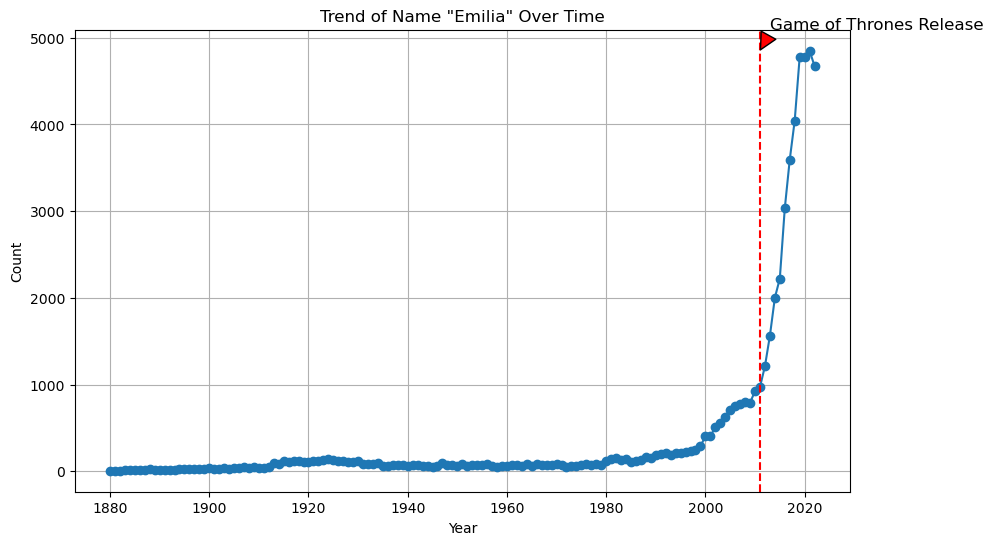

In [29]:
# Plot name of Kit for Harington
plot_name_trend(national_df, 'Emilia', show_year=2011, show_name="Game of Thrones")

### Schitt's Creek Analysis

In [30]:
#Load Schitt's Creek data
schitts_creek_df = pd.read_csv("Data/List_of_Schitts_Creek_characters_characters.csv")

# Apply function to create new column
schitts_creek_df['character_first_name'] = schitts_creek_df['character_name'].apply(lambda x: extract_first_name(x))

# Display the updated DataFrame
schitts_creek_df.head()

,actor_name,character_name,character_first_name
0,Eugene Levy,Johnny Rose,Johnny
1,Catherine O'Hara,Moira Rose,Moira
2,Daniel Levy,David Rose,David
3,Annie Murphy,Alexis Rose,Alexis
4,Jennifer Robertson,Jocelyn Schitt,Jocelyn


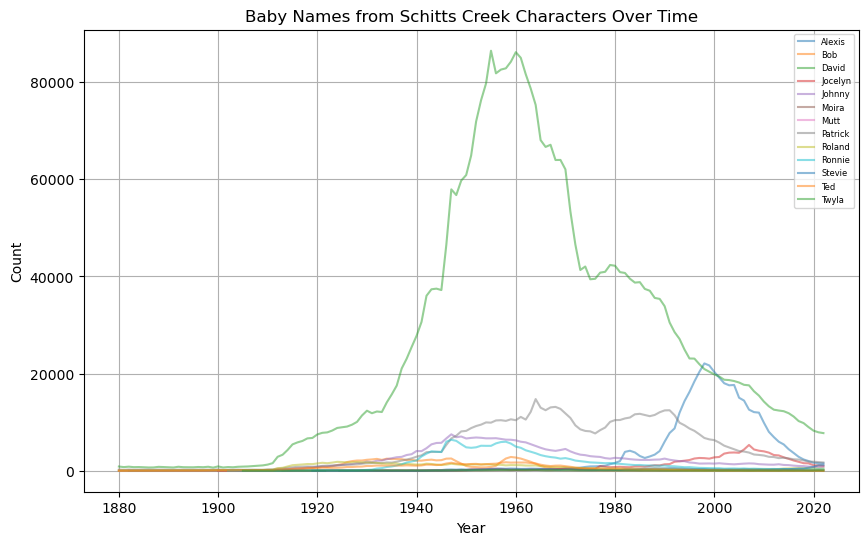

In [31]:
grouped_schitts_creek_df = filter_and_group_names(national_df, schitts_creek_df, 'character_first_name')

plt.figure(figsize=(10, 6))
lines = []
for name, data in grouped_schitts_creek_df.groupby('name'):
    line, = plt.plot(data['year'], data['count'], label=name, alpha=0.5)
    lines.append(line)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Baby Names from Schitts Creek Characters Over Time')

plt.legend(fontsize='6')

plt.grid(True)

# Add hover
cursor = mplcursors.cursor(hover=True)

#below hover section code configuration was assisted by generatiove AI
@cursor.connect("add")
def on_hover(sel):
    sel.annotation.set_text(sel.artist.get_label())
    for line in lines:
        if line != sel.artist:
            line.set_alpha(0.2)  # Grey out non hover lines
        else:
            line.set_alpha(1.0)  # Highlight hovered line

plt.show()

In [32]:
# Get name counts for "Stevie" 
national_group_df[(national_group_df['name'] == 'Stevie') & (national_group_df['year'] > 2000)]

,name,year,count
1669710,Stevie,2001,236
1669711,Stevie,2002,217
1669712,Stevie,2003,232
1669713,Stevie,2004,215
1669714,Stevie,2005,211
1669715,Stevie,2006,252
1669716,Stevie,2007,229
1669717,Stevie,2008,217
1669718,Stevie,2009,240
1669719,Stevie,2010,210


In [33]:
# Calculate popularity increase for 'Stevie'
print("Popularity Increase for Stevie:")
calculate_popularity_increase(national_group_df, 'Stevie', 2015, 2022)

Popularity Increase for Stevie:


'290.06%'

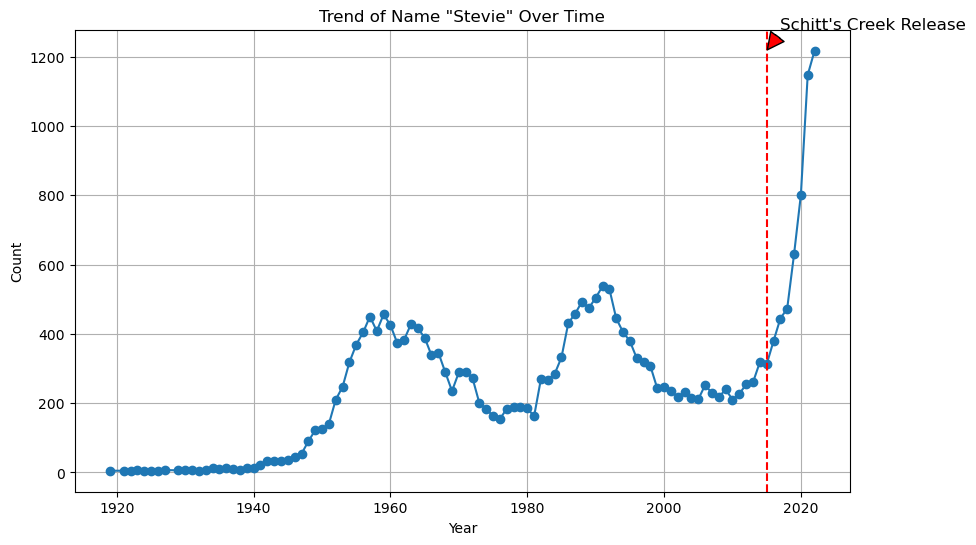

In [34]:
# Plot name of character Stevie 
plot_name_trend(national_df, 'Stevie', show_year=2015, show_name="Schitt's Creek")